In [1]:
!nvidia-smi

Tue Dec 20 14:09:20 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla T4            Off  | 00000000:00:05.0 Off |                    0 |
| N/A   

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

2022-12-20 14:09:26.289538: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-20 14:09:26.659728: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-20 14:09:26.661027: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-20 14:09:26.811625: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

In [3]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.efficientnet import EfficientNetB7
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob

In [4]:
IMAGE_SIZE = (224, 224, 3)

train_path = '/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets'

In [5]:
nasnetL = EfficientNetB7(input_shape=IMAGE_SIZE, include_top=False, weights="imagenet")

2022-12-20 14:09:30.570884: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-20 14:09:30.571786: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-20 14:09:30.572530: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-20 14:09:30.573214: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-20 14:09:30.573881: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

258088960/258076736 [==============================] - 2s 0us/step


In [6]:
for layer in nasnetL.layers:
    layer.trainable = False

In [7]:
folders = glob('/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/*')

In [8]:
x = Flatten()(nasnetL.output)

In [9]:
prediction = Dense(len(folders), activation='softmax')(x)
model = Model(inputs=nasnetL.input, outputs=prediction)

In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
______________________________________________________________________________________________

In [11]:
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
data = ImageDataGenerator(validation_split = 0.2,
                          rescale = 1./224,
                          shear_range = 0.2,
                          zoom_range = 0.2,
                          horizontal_flip = True)

In [13]:
training_set = data.flow_from_directory('/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets',
                                                 target_size = (224, 224),
                                                 batch_size = 64,
                                                 subset = "training",
                                                 class_mode = 'categorical')

Found 12000 images belonging to 3 classes.


In [14]:
test_set = data.flow_from_directory('/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets',
                                            target_size = (224, 224),
                                            batch_size = 64,
                                            subset = "validation",
                                            class_mode = 'categorical')

Found 3000 images belonging to 3 classes.


In [15]:
r = model.fit(
  training_set,
  validation_data=test_set,
  epochs=10,
  verbose=True,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

2022-12-20 14:09:49.763922: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2022-12-20 14:10:09.716668: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005
2022-12-20 14:10:18.285116: W tensorflow/core/common_runtime/bfc_allocator.cc:338] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.


188/188 [==============================] - 429s 2s/step - loss: 10.1414 - accuracy: 0.3359 - val_loss: 20.9024 - val_accuracy: 0.3333
Epoch 2/10
188/188 [==============================] - 348s 2s/step - loss: 6.5375 - accuracy: 0.3282 - val_loss: 14.6306 - val_accuracy: 0.3333
Epoch 3/10
188/188 [==============================] - 348s 2s/step - loss: 8.9760 - accuracy: 0.3352 - val_loss: 6.8580 - val_accuracy: 0.3333
Epoch 4/10
188/188 [==============================] - 348s 2s/step - loss: 7.1480 - accuracy: 0.3382 - val_loss: 2.1784 - val_accuracy: 0.3333
Epoch 5/10
188/188 [==============================] - 348s 2s/step - loss: 10.4369 - accuracy: 0.3231 - val_loss: 7.1606 - val_accuracy: 0.3333
Epoch 6/10
188/188 [==============================] - 347s 2s/step - loss: 14.8608 - accuracy: 0.3428 - val_loss: 13.4752 - val_accuracy: 0.3333
Epoch 7/10
188/188 [==============================] - 349s 2s/step - loss: 13.1648 - accuracy: 0.3339 - val_loss: 10.2026 - val_accuracy: 0.3333
Ep

In [16]:
import matplotlib.pyplot as plt

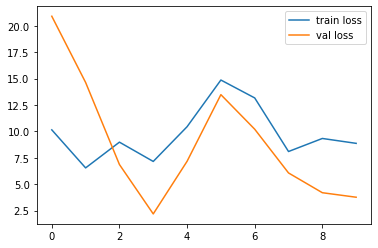

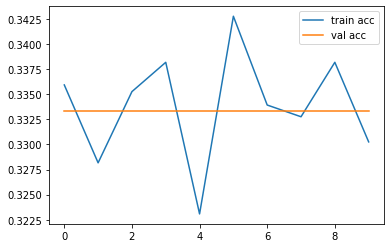

<Figure size 432x288 with 0 Axes>

In [17]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [18]:
from tensorflow.keras.models import load_model

model.save('model_densenet.h5')

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [19]:
y_pred = model.predict(test_set)

In [20]:
y_pred

array([[0.01066591, 0.00144804, 0.9878861 ],
       [0.0086349 , 0.00125054, 0.99011457],
       [0.00792995, 0.00100172, 0.99106824],
       ...,
       [0.00867592, 0.00112181, 0.9902022 ],
       [0.00929204, 0.00123811, 0.9894699 ],
       [0.00764319, 0.00101304, 0.99134374]], dtype=float32)

In [21]:
from sklearn.metrics import classification_report

Y_pred = model.predict(test_set)
y_pred = np.argmax(Y_pred, axis=1)

print(classification_report(test_set.classes, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1000
           1       0.00      0.00      0.00      1000
           2       0.33      1.00      0.50      1000

    accuracy                           0.33      3000
   macro avg       0.11      0.33      0.17      3000
weighted avg       0.11      0.33      0.17      3000



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [22]:
import itertools
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [23]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, weight='bold', fontsize=16)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=14)
    plt.yticks(tick_marks, classes, fontsize=14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center", fontsize=12, weight='bold',
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', fontsize=16, weight='bold')
    plt.xlabel('Predicted label', fontsize=16, weight='bold')

Normalized confusion matrix


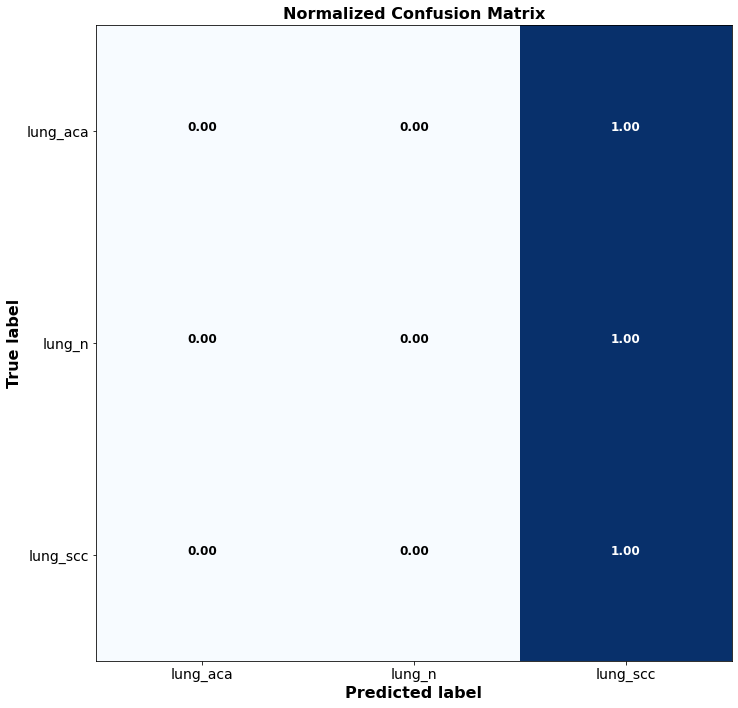

In [24]:
cnf_matrix = confusion_matrix(test_set.classes, y_pred)
np.set_printoptions(precision=2)
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=['lung_aca', 'lung_n', 'lung_scc'],normalize=True,
                      title='Normalized Confusion Matrix')
plt.show()